In [2]:
# 02_train_anomaly.ipynb

import os
import sys

# Make project root importable: assumes this notebook is in amos/notebooks/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

from src.config import PROCESSED_DATA_PATH, ANOMALY_MODEL_PATH
from src.preprocessing.etl import create_processed_dataset
from src.models.anomaly_model import train_anomaly_model, save_anomaly_model, compute_anomaly_score
from src.preprocessing.features import get_feature_columns


In [3]:
# Ensure processed dataset exists (runs ETL if needed)
processed_path = create_processed_dataset(force=False)
print("Using processed data at:", processed_path)

df = pd.read_csv(PROCESSED_DATA_PATH)
df.head()


Using processed data at: /home/leo/AMOS/data/processed/ai4i2020_prepared.csv


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp_diff,Power_proxy,Tool_wear_norm
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,66382.8,0.000000
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,65190.4,0.011858
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,74001.2,0.019763
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,56603.5,0.027668
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,56320.0,0.035573


In [4]:
print(df.shape)
df.info()
df.describe().T.head(15)


(10000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
 12  Temp_diff                10000 non-null  float64
 13  Power_proxy              10000 non-null  float64
 14  Tool_wear_n

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.004930,2.000259,295.3,298.300000,300.100000,301.500000,304.5
Process temperature [K],10000.0,310.005560,1.483734,305.7,308.800000,310.100000,311.100000,313.8
Rotational speed [rpm],10000.0,1538.776100,179.284096,1168.0,1423.000000,1503.000000,1612.000000,2886.0
Torque [Nm],10000.0,39.986910,9.968934,3.8,33.200000,40.100000,46.800000,76.6
Tool wear [min],10000.0,107.951000,63.654147,0.0,53.000000,108.000000,162.000000,253.0
Machine failure,10000.0,0.033900,0.180981,0.0,0.000000,0.000000,0.000000,1.0
TWF,10000.0,0.004600,0.067671,0.0,0.000000,0.000000,0.000000,1.0
HDF,10000.0,0.011500,0.106625,0.0,0.000000,0.000000,0.000000,1.0
PWF,10000.0,0.009500,0.097009,0.0,0.000000,0.000000,0.000000,1.0
OSF,10000.0,0.009800,0.098514,0.0,0.000000,0.000000,0.000000,1.0


In [5]:
# Train anomaly model on processed dataframe
anomaly_model = train_anomaly_model(df)
print("Anomaly model trained.")


Anomaly model trained.


In [6]:
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay

# We use Machine failure labels only for evaluation
y_true = df["Machine failure"].values

X_raw, _, _ = get_feature_columns(df)
anomaly_scores = compute_anomaly_score(anomaly_model, X_raw)

roc_auc = roc_auc_score(y_true, anomaly_scores)
print("ROC-AUC (anomaly score vs Machine failure):", roc_auc)


ROC-AUC (anomaly score vs Machine failure): 0.8351603121634623


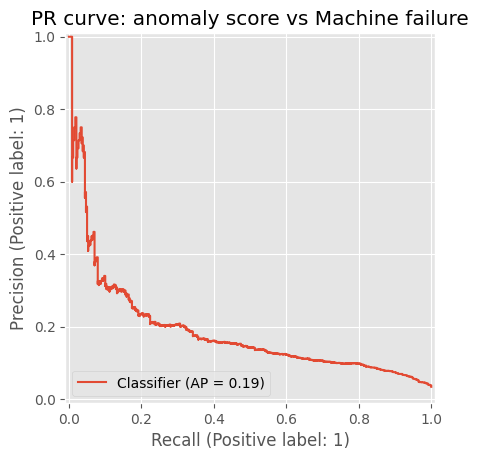

In [7]:
PrecisionRecallDisplay.from_predictions(y_true, anomaly_scores)
plt.title("PR curve: anomaly score vs Machine failure")
plt.show()


In [8]:
save_anomaly_model(anomaly_model, ANOMALY_MODEL_PATH)
print("Anomaly model saved to:", ANOMALY_MODEL_PATH)


Anomaly model saved to: /home/leo/AMOS/models/anomaly/isolation_forest.pkl
